In [1]:
import xarray as xr
from utils.data import *
from utils.utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import proplot

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
province = 'istanbul'

# numbers starting with 2 or 3: urban
# numbers starting with 1 except 10: rural
# number 10: water
urban_tiles = [21,22,23,30]
rural_tiles = [11,12,13]

## 1. Number of Days Analysis

In [3]:
temp_threshold = 30
lu_year = 2015 # 2000, 2015
chirts_year = 2015 # 2000, 2005, 2010, 2015

In [4]:
ds_tmax = xr.open_dataset(fr'data/common/chirts/chirts_tmax_{chirts_year}.nc').tmax
ds_tmax = ds_tmax.rio.write_crs(4326)

In [5]:
ds_lu = retrieve_ghs(province=province).sel(time=lu_year)

In [6]:
ds_tmax_clipped = clip_subroutine(ds_tmax, province, 'X', 'Y')

In [7]:
ds_threshold_days = xr.where(ds_tmax_clipped>=temp_threshold, 1, 0).sum(dim='T')

In [8]:
ds_threshold_days, ds_lu_repr = regrid_match(ds_threshold_days, ds_lu, ds_threshold_days.rio.crs, ds_lu.rio.crs,
                                             'X', 'Y',
                                             'x', 'y')

In [9]:
ds_lu_repr = xr.where(ds_lu_repr<0, np.nan, ds_lu_repr)

In [10]:
ds_lu_repr_class = classify_urban_rural(ds_lu_repr, urban_tiles, rural_tiles) 

In [11]:
# interpolate
Y_dir, X_dir = ds_lu_repr_class.indexes.values()
ds_threshold = ds_threshold_days.interp(X=X_dir, Y=Y_dir, method="nearest") # interp to model grid

In [12]:
urban_threshold_days = xr.where(ds_lu_repr_class==1, ds_threshold, np.nan)
rural_threshold_days = xr.where(ds_lu_repr_class==0, ds_threshold, np.nan)

In [13]:
print(np.nanmedian(urban_threshold_days))
print(np.nanmedian(rural_threshold_days))

17.0
12.5


In [185]:
print(np.max(urban_threshold_days).values)
print(np.max(rural_threshold_days).values)

42.0
44.0


## 2. Creating PDF Plots

In [14]:
ds_chirts = xr.open_mfdataset(r'data/common/chirts/chirts_tmax*').tmax
ds_chirts = ds_chirts.rio.write_crs(4326)

In [15]:
provinces = ['istanbul', 'ankara']
chirts_data_dict = {}

# add urban and rural variables to the given province chirts data
for province in provinces:
    
    ds_chirts_clipped = clip_subroutine(ds_chirts, province, 'X', 'Y')
    ds_lu = retrieve_ghs(province=province).sel(time=2000)    
    
    ds_lu_repr, ds_chirts_clipped = regrid_match(ds_lu, ds_chirts_clipped,  
                                                 ds_lu.rio.crs, ds_chirts_clipped.rio.crs,
                                                 'x', 'y',
                                                 'X', 'Y')   
    
    ds_lu_repr = xr.where(ds_lu_repr<0, np.nan, ds_lu_repr)    
    ds_lu_repr_class = classify_urban_rural(ds_lu_repr, urban_tiles, rural_tiles)    
    
    ds_chirts_copy = xr.where(ds_chirts_clipped>500, np.nan, ds_chirts_clipped).to_dataset(name='tmax')
    ds_chirts_copy_class = ds_chirts_copy.assign(urban = lambda x: xr.where(ds_lu_repr_class==1, x.tmax, np.nan)).transpose('T', 'y', 'x')
    ds_chirts_copy_class = ds_chirts_copy_class.assign(rural = lambda x: xr.where(ds_lu_repr_class==0, x.tmax, np.nan)).transpose('T', 'y', 'x')  
   
    chirts_data_dict[province] = ds_chirts_copy_class

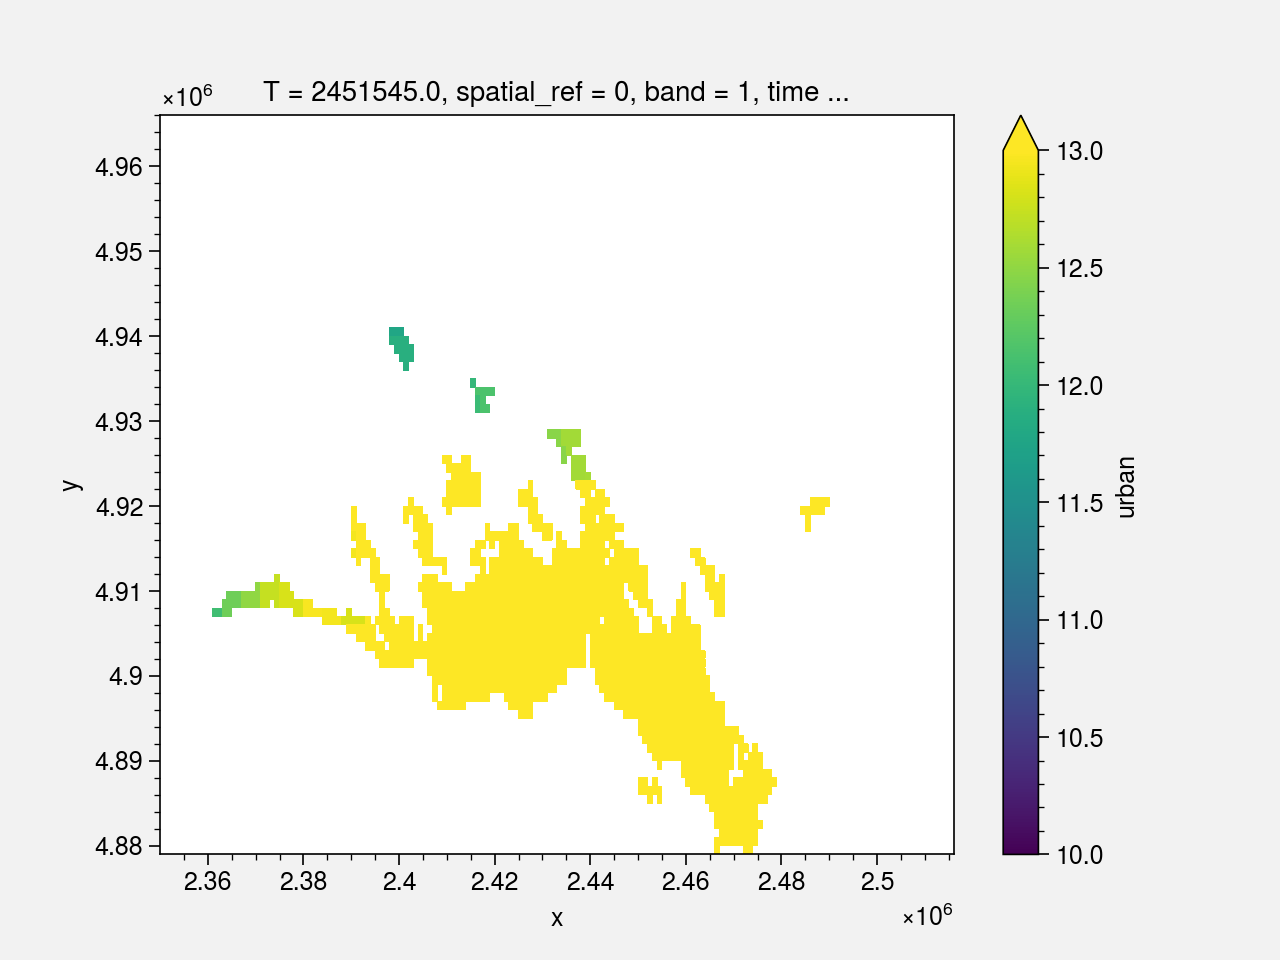

In [16]:
chirts_data_dict['istanbul'].urban[0].plot(vmin=10, vmax=13)

/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/ui.py:406: ProPlotWarning: You specified both figsize=(6, 3) and axwidth=1.5. Ignoring 'axwidth'.
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = f

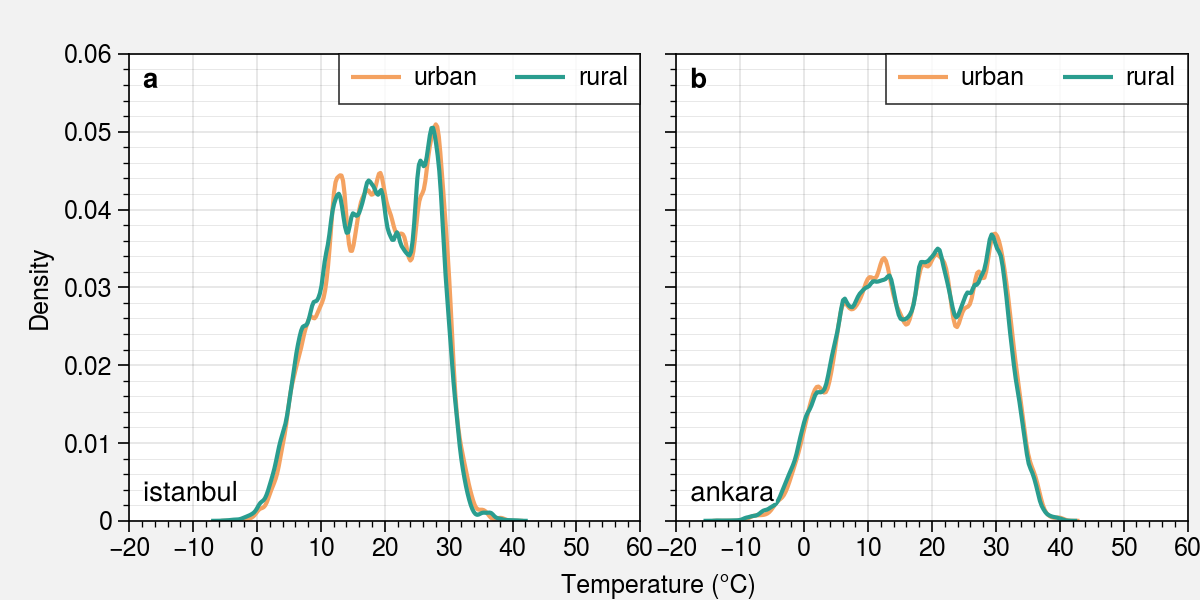

In [195]:
# start figure
f, axs = proplot.subplots(array=[[1, 2]], hratios=(1),
                          hspace=0.20, figsize=(6,3),
                          share=3, axwidth=1.5, tight=False)

# colors for lines
color_map = {'urban': '#f4a261',
             'rural': '#2a9d8f'}

# make kdeplots containing urban and rural temperature distributions
for i, province in enumerate(provinces):
    
    # flatten and make a list out of the xarray datasets before plotting
    flatten_data_urban = remove_nan_from_array(np.array(chirts_data_dict[province]['urban']).flatten())
    flatten_data_rural = remove_nan_from_array(np.array(chirts_data_dict[province]['rural']).flatten())
    
    sns.kdeplot(flatten_data_urban, ax=axs[i], color=color_map['urban'], label='urban', legend=True)
    sns.kdeplot(flatten_data_rural, ax=axs[i], color=color_map['rural'], label='rural', legend=True)

# format subfigures
for i in range(2):
    axs[i].format(ylabel='Density', xlabel='Temperature (°C)',
                  ygridminor=True, ygrid=True, title=provinces[i],
                  titleloc='ll', xrotation=0, xlim=(-20, 60), ylim=(0, 0.06),
                  xlocator=proplot.arange(-20, 60, 10))

# format whole figure
axs.format(abcloc='ul', abc=True,)
axs.legend()
    
# savefig    
plt.savefig(fr'pictures/chirts_pdf_fig.jpeg',
            bbox_inches='tight', optimize=False,
            progressive=True, dpi=300)